# Predictors of Student Performance in School
## Introduction

For students, juggling high grades and a social life can be a stressful endeavor. Oftentimes students can overstudy for exams in order to achieve their desired grade. This leads to unneeded sacrifices being made in the other facets of a student's life. Performance in school often feels like a guessing game of whether you have put enough time into learning. Because of this, our group has decided to investigate how factors affect the performance of students in school . We are trying to answer the question: How can students spend their time more efficently to pass their classes? The data set we used is "Students Performance Data Set" compiled by Paulo Cortez, a professor at the Unversity of Minho in Portugal. This data set contains attributes about academic achievement, demographics, and the social and academic environment of a Portuguese language course, collected by survey in 2 Portuguese Secondary schools. 

## Methods and Results

In [2]:
# Required libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
# Reading the data set from the web into R
student_data <- read_delim("https://raw.githubusercontent.com/gpark8910/DSCI100_project/main/student-por.csv",
                          delim = ";")
student_data

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,4,0,11,11
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,2,9,11,11
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,6,12,13,12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,F,18,U,GT3,T,1,1,other,other,⋯,1,1,1,1,1,5,6,11,12,9
MS,M,17,U,LE3,T,3,1,services,services,⋯,2,4,5,3,4,2,6,10,10,10
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,4,10,11,11


In [4]:
# Tidying and selecting the variables to use as predictors
mutated_data <- select(student_data, traveltime, studytime, freetime, goout, G1, G2, G3) %>% # Details about our variables in "Methods"
                mutate(G3 = case_when(
                   G3 <= 9 ~ "fail",
                   G3 >= 10 ~ "pass")) %>% 
                mutate(G3 = as_factor(G3))
mutated_data
head(mutated_data)
tail(mutated_data)

traveltime,studytime,freetime,goout,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,2,3,4,0,11,pass
1,2,3,3,9,11,pass
1,2,3,2,12,13,pass
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,2,1,1,11,12,fail
2,1,4,5,10,10,pass
3,1,4,1,10,11,pass


traveltime,studytime,freetime,goout,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,2,3,4,0,11,pass
1,2,3,3,9,11,pass
1,2,3,2,12,13,pass
1,3,2,2,14,14,pass
1,2,3,2,11,13,pass
1,2,4,2,12,12,pass


traveltime,studytime,freetime,goout,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,1,4,3,7,9,pass
1,3,4,2,10,11,pass
1,2,3,4,15,15,pass
2,2,1,1,11,12,fail
2,1,4,5,10,10,pass
3,1,4,1,10,11,pass


In [5]:
predictors_means <- mutated_data %>% 
   summarize(travel_time_mean = mean(traveltime),
             study_time_mean = mean(studytime),
             free_time_mean = mean(freetime),
             go_out_time_mean = mean(goout),
             grade1_mean = mean(G1),
             grade2_mean = mean(G2)) 
predictors_means

travel_time_mean,study_time_mean,free_time_mean,go_out_time_mean,grade1_mean,grade2_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.568567,1.930663,3.180277,3.1849,11.39908,11.57011


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



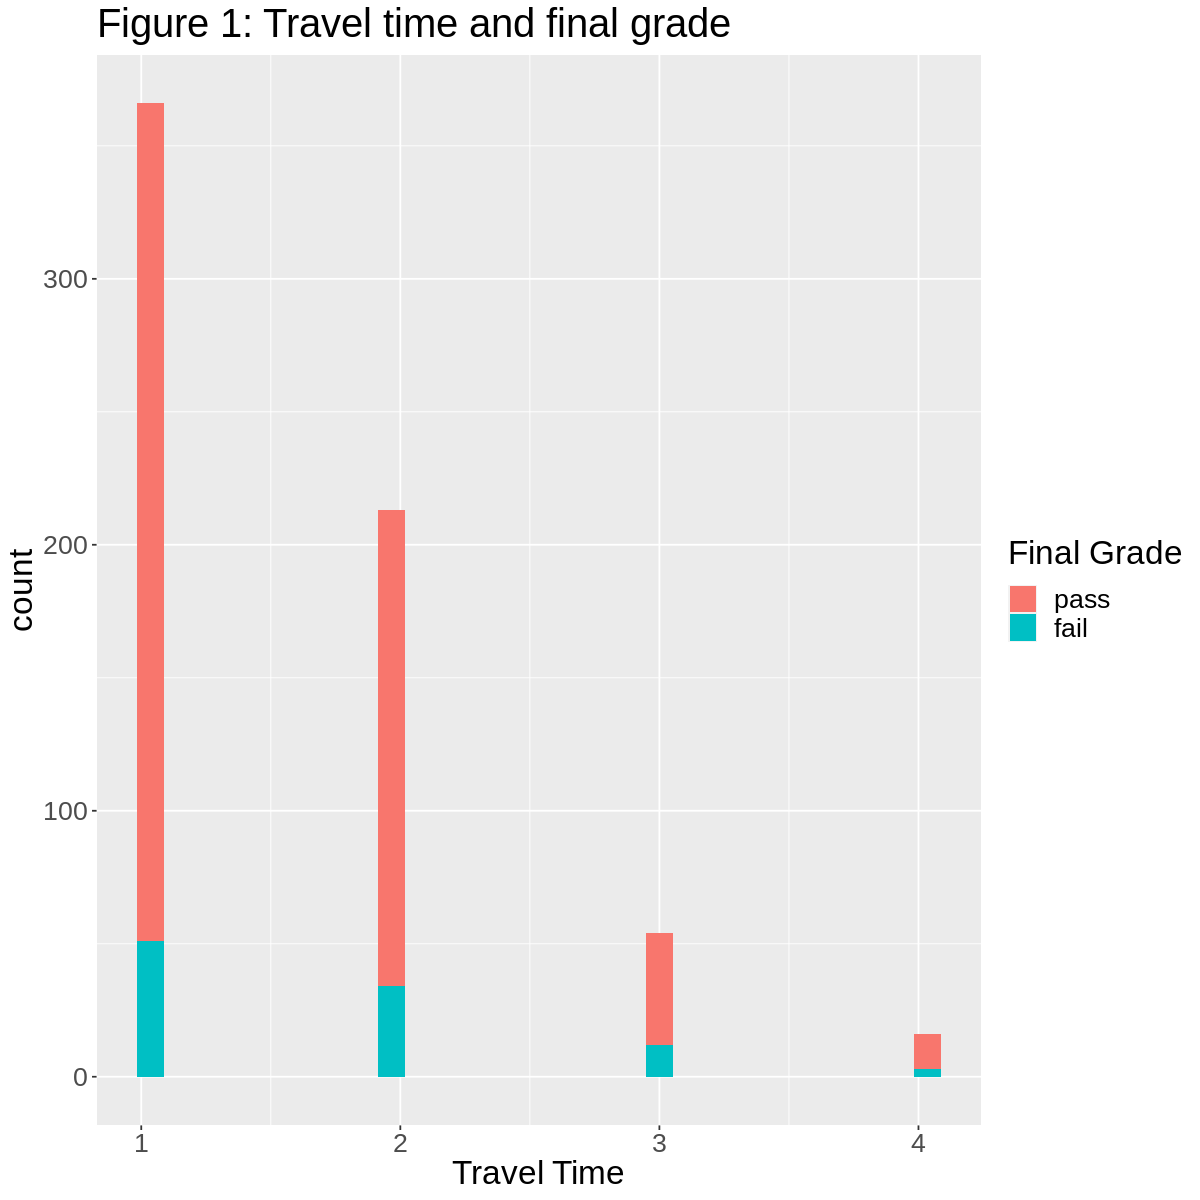

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



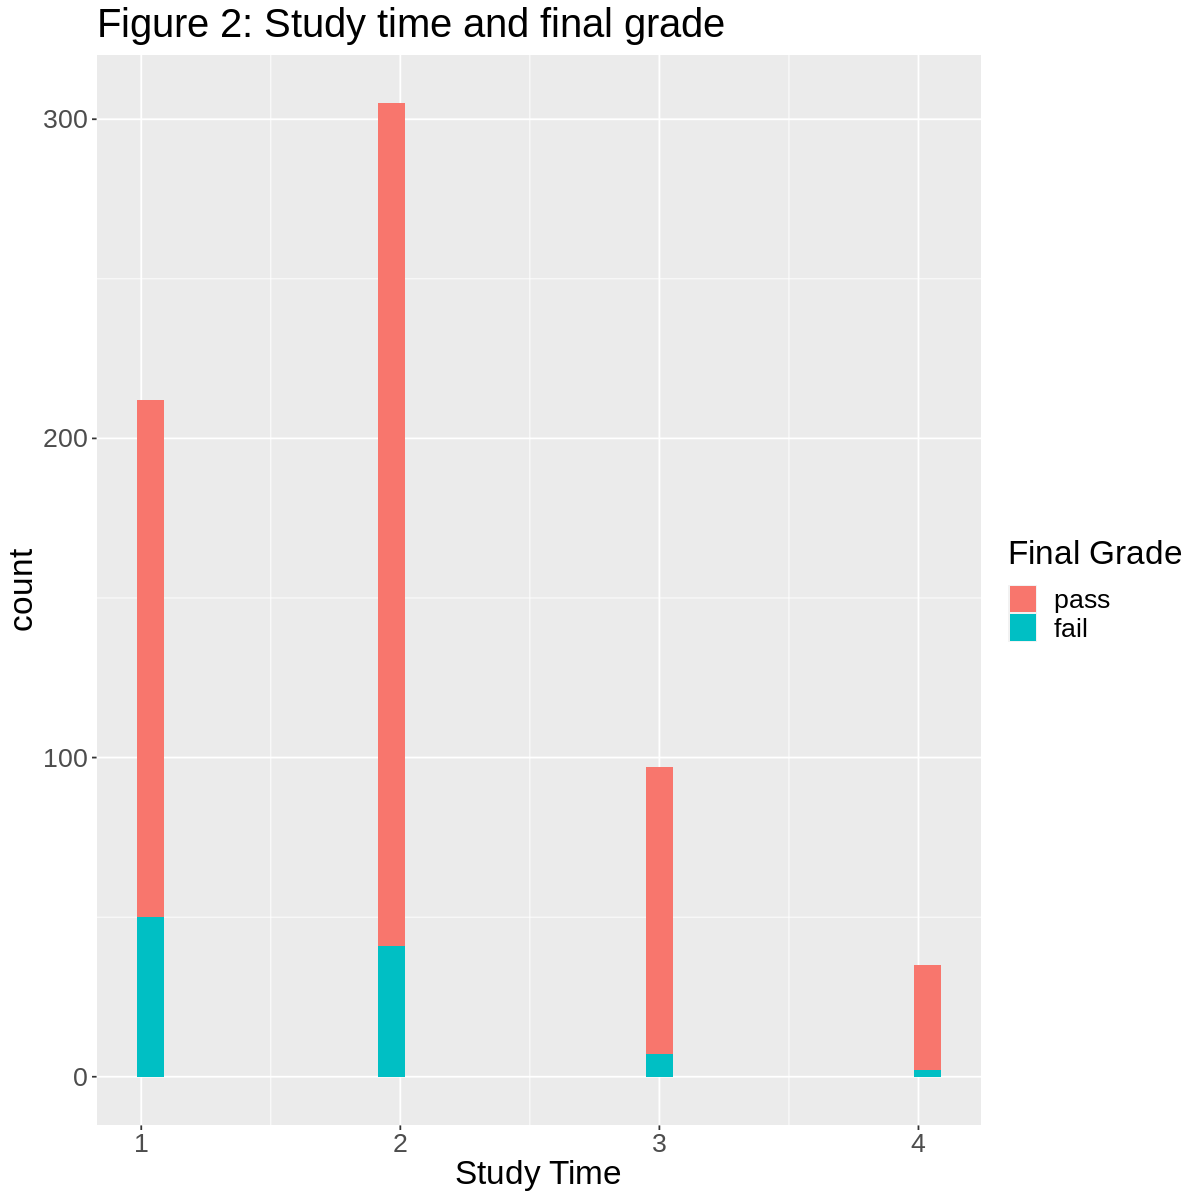

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



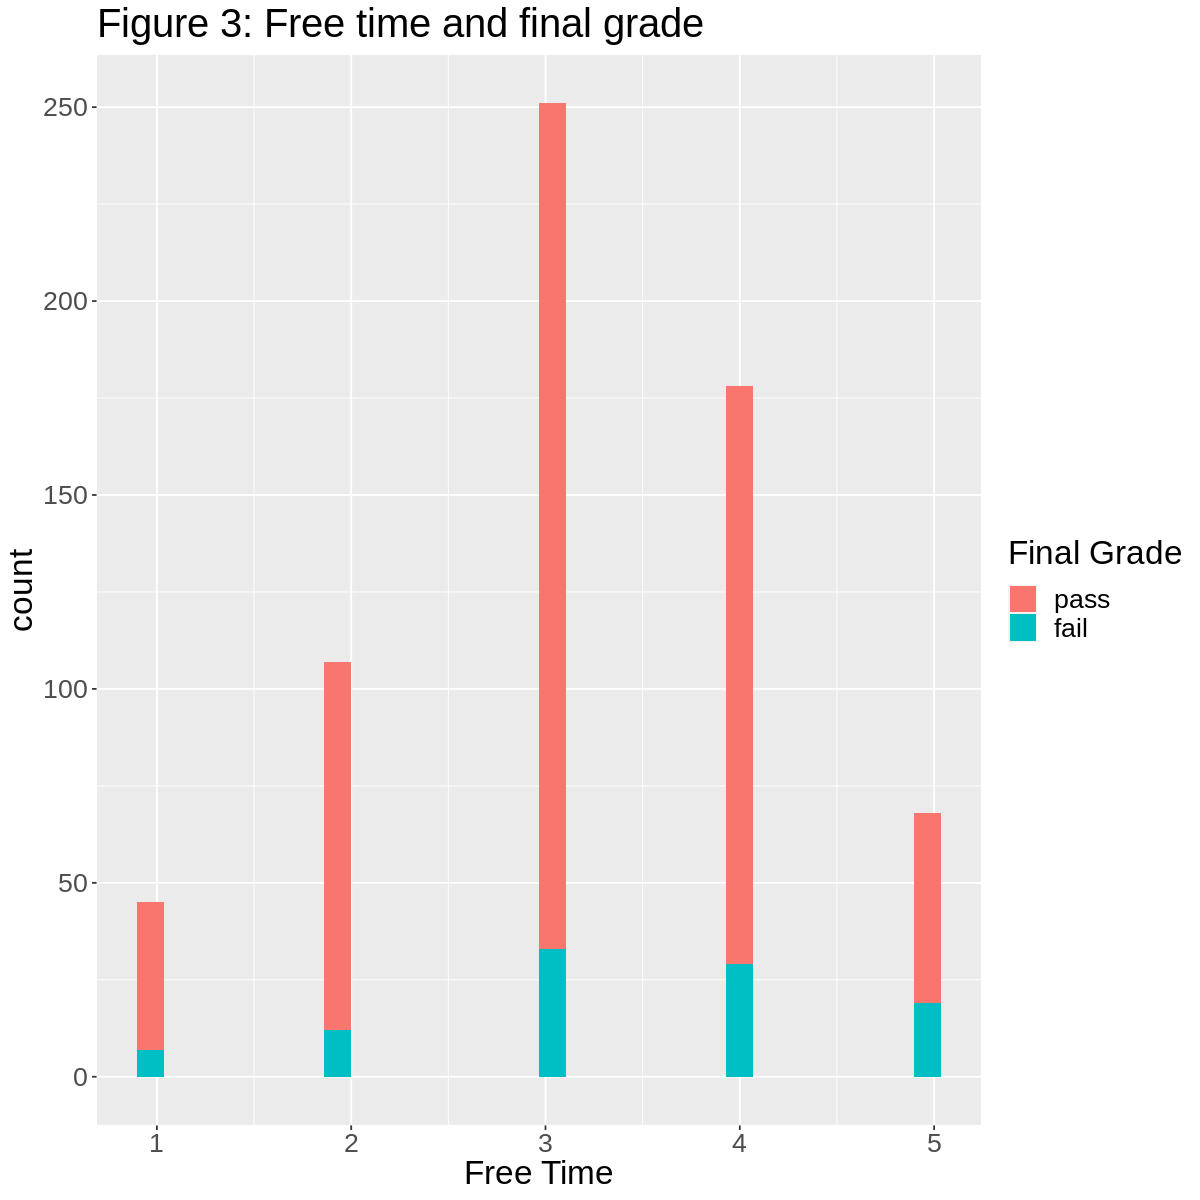

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



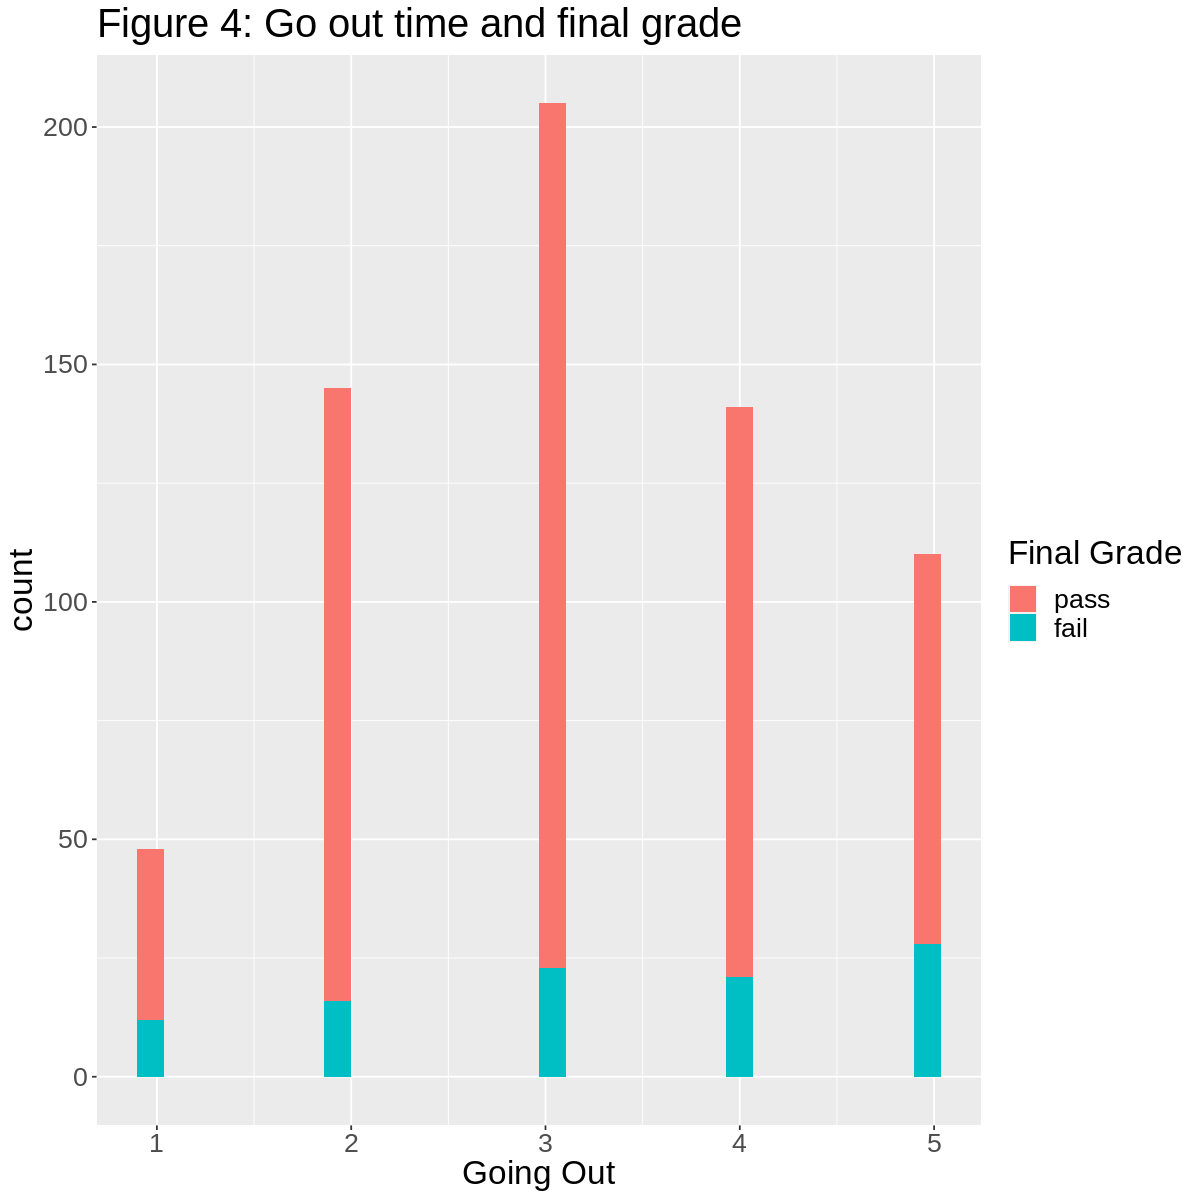

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



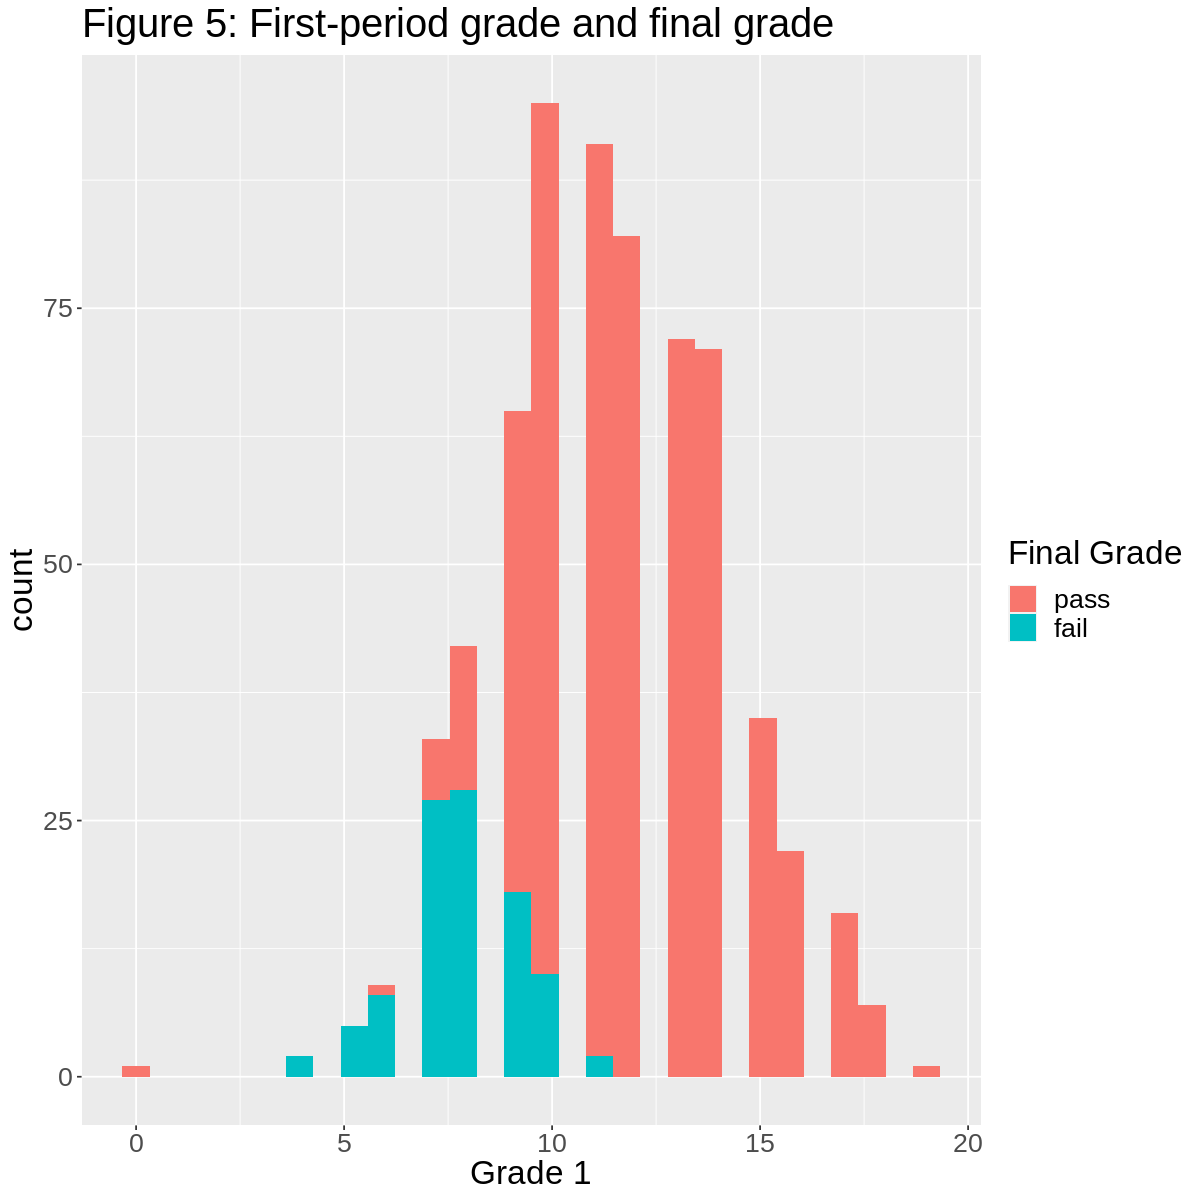

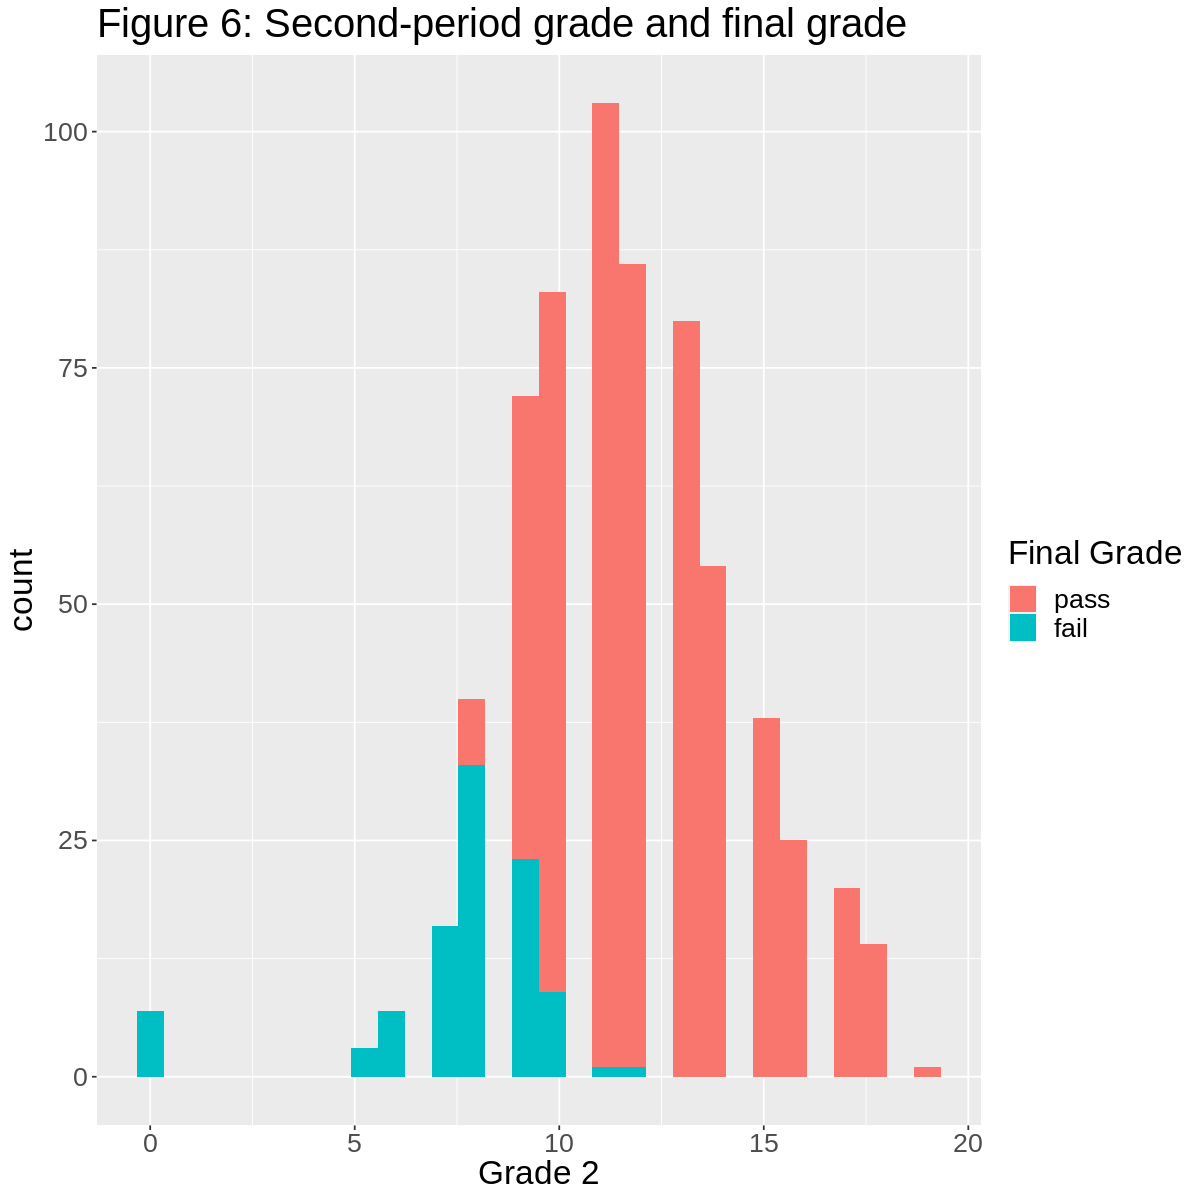

In [10]:
#create visualization for the data
options(repr.plot.width = 10, repr.plot.height = 10) 

travel_time_distribution <- mutated_data %>% 
   ggplot(aes(x = traveltime, fill = G3)) +
   geom_histogram(bins=30) +
   labs(x = "Travel Time", fill = "Final Grade") +
   theme(text = element_text(size = 20))  +
   ggtitle("Figure 1: Travel time and final grade")

travel_time_distribution

study_time_distribution <- mutated_data %>% 
   ggplot(aes(x = studytime, fill = G3)) +
   geom_histogram() +
   labs(x = "Study Time", fill = "Final Grade") +
   theme(text = element_text(size = 20)) +
   ggtitle("Figure 2: Study time and final grade")

study_time_distribution

free_time_distribution <- mutated_data %>% 
   ggplot(aes(x = freetime, fill = G3)) +
   geom_histogram() +
   labs(x = "Free Time", fill = "Final Grade") +
   theme(text = element_text(size = 20)) +
   ggtitle("Figure 3: Free time and final grade")

free_time_distribution

goout_time_distribution <- mutated_data %>% 
   ggplot(aes(x = goout, fill = G3)) +
   geom_histogram() +
   labs(x = "Going Out", fill = "Final Grade") +
   theme(text = element_text(size = 20)) +
   ggtitle("Figure 4: Go out time and final grade") 

goout_time_distribution

grade_1_distribution <- mutated_data %>% 
   ggplot(aes(x = G1, fill = G3)) +
   geom_histogram() +
   labs(x = "Grade 1", fill = "Final Grade") +
   theme(text = element_text(size = 20)) +
   ggtitle("Figure 5: First-period grade and final grade")

grade_1_distribution

grade_2_distribution <- mutated_data %>% 
   ggplot(aes(x = G2, fill = G3)) +
   geom_histogram() +
   labs(x = "Grade 2", fill = "Final Grade") +
   theme(text = element_text(size = 20)) +
   ggtitle("Figure 6: Second-period grade and final grade")

grade_2_distribution

## Methods add this to the previous section somehow?

We have selected 6 predictors for our study to predict the final grade of students.
* Travel Time: Time spent travelling between home and school
* Study Time: Weekly time spent studying
* Free Time: Free time after school
* Go Out: Going out with friends
* G1: First period grade
* G2: Second period grade
* G3: Final grade

Since G3 had such a wide range, we regrouped it into two classes, fail or pass. A final grade of 0-9 would equal a failing grade, and 10-20 would equal to a passing grade. To reclassify column G3, we used a new function called case_when.

We plan to use histograms to visualize our data.

We plan to use K-nearest neighbor classification to predict the relationship between other predictors and whether they could pass the final. We will split the data set into training set and testing set. We would use testing set to test the feasibility of our model. 

### Predictors and Justification add this to the part above?

As stated above, we chose 6 predictors to predict or not a student will pass or fail the course. Besides each predictor, we have written the reason for choosing it for our data analysis.

* Travel Time: As the time used to travel to and from school increases, the amount of time a student spends studying decreases. Additionally, long trips could tire students out both mentally and physically. In both of these scenarios, a student's grade can be affected. Because of this, 'Travel Time' can help us predict a student's final grade.

* Study Time: The amount of time a student has to study is directly correlated with their preparedness for exams and even assignments, leading to higher overall grades. The more time one has to study, the more time one can dedicate to learning. Overall, 'Study Time" is a variable that can help us predict a student's final grade.

* Free Time: The amount of time a student has to indulge in their hobbies and relax (time spent not studying or doing homework) directly contributes to the mental well-being of the student. Too little free time could negatively affect a student's ability to focus and study. Additionally, too much free time could decrease the amount of time a student has to study, leading to lower grades. Overall, 'Free Time' is a variable that can predict a student's final grade.

* Go Out: The amount of time a student spends going can affect their final grade. Going out too much can decrease the amount of study time a student has (which can lead to lower grades). Additionally, too little going out time can negatively affect student mentality, decreasing the effectiveness of studying overall. While the exact effects of 'Go Out' on grades are well-defined, the variable is valuable for predicting a student's final grade.

* G1: First-period grades are a strong indicator of future grades. If one's first-period grades are low, the student will likely have consistently low grades throughout the entire term. Because of this, 'G1' is a variable that can help us predict a student's final grade.

* G2: Like first-period grades, second-period grades are a strong indicator of the final grade. If one's second-period grades are low, the student will likely have a low final grade as well. Because of this, 'G2' is a variable that can help us predict a student's final grade.


## Discussion




## Expected Outcomes and Significance idk where to put this??
We expect to see a positive relationship between the amount of time spent studying and the proportion of students that pass the class. This relationship holds true for period 1 and period 2 grades as well. As a student's period 1 and period 2 grades increase, the likelihood that they pass the course also increases. We also expect to see a negative relationship between the amount of time a student does not spend studying (the amount of time a student has to commute to school, the amount of free time a student has, and the amount of time a student goes out with their freinds) and the proportion of students that pass the class. The impact of this finding would mean that students have to sacrifice personal free-time in order to achieve higher grades and pass their courses. However this leads to a different question. How would a student find a balance between study and leisure time that would allow them to not only acheive a passing grade but also allow the student to engage in extracuricular and social activities?

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,accuracy,binary,0.9074286,10,0.01002799,Model04


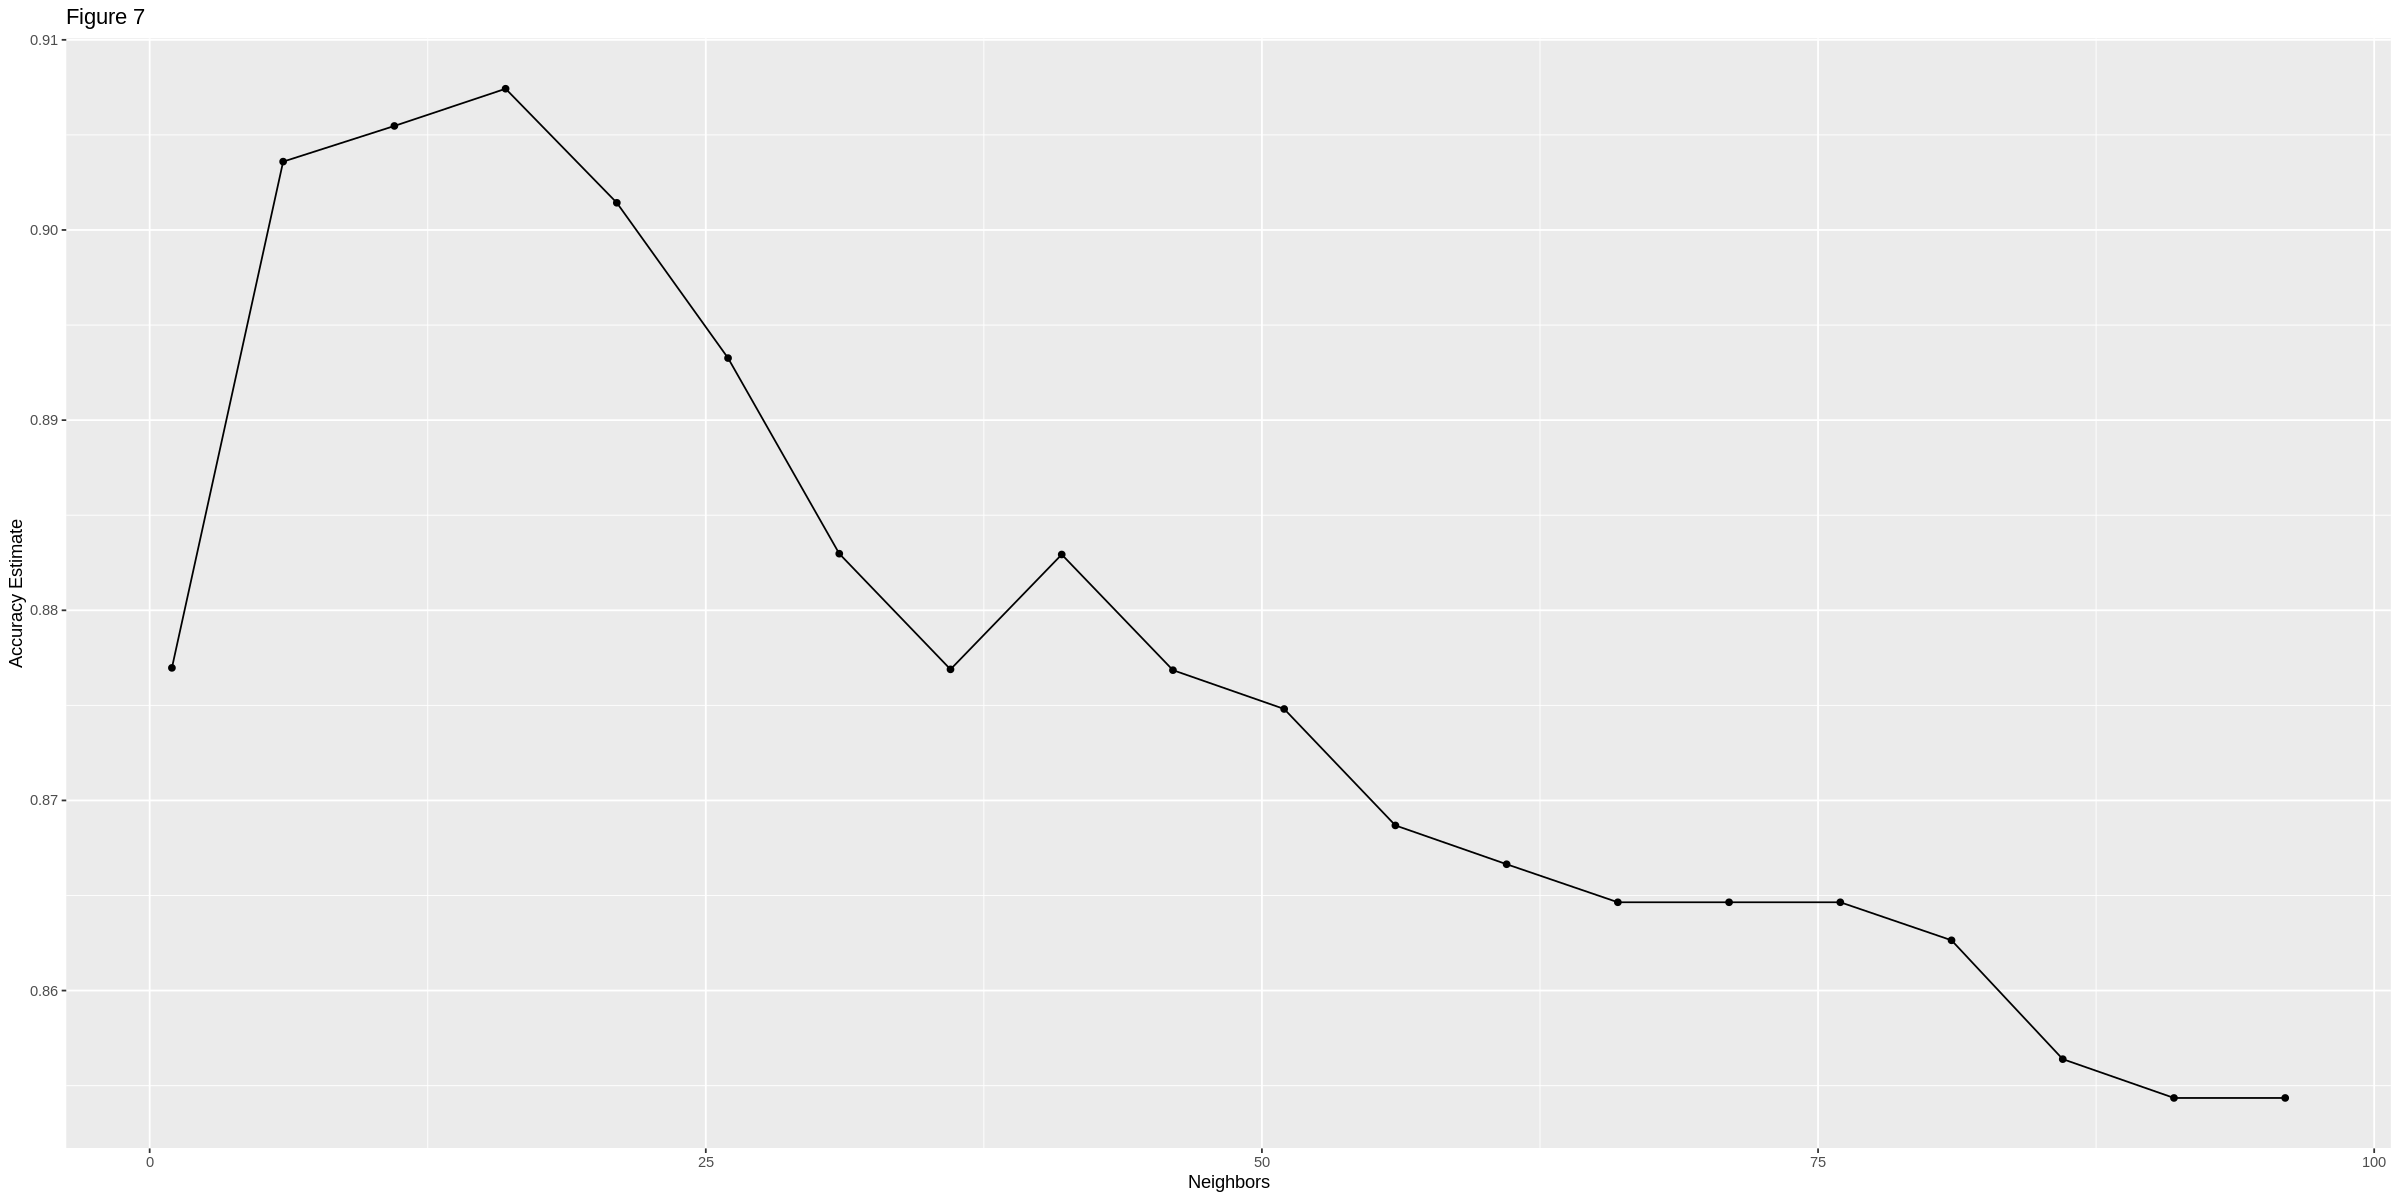

In [7]:
set.seed(5)
# find the optimal k 
options(repr.plot.height = 10, repr.plot.width = 20)
grade_split <- initial_split(mutated_data, prop = 0.75, strata = G3)
grade_train <- training(grade_split)
grade_test <- testing(grade_split) 

grade_recipe <- recipe(G3 ~. , data = grade_train) %>% 
   step_scale(all_predictors()) %>% 
   step_center(all_predictors())

# perform a 10-fold cross validation to find the best K
grade_vfold <- vfold_cv(grade_train, v = 10, strata = G3)

# parameter value selection
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
   set_engine("kknn") %>% 
   set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# fit the knn model (reuse the recipe and model from before)
knn_fit <- workflow() %>% 
   add_recipe(grade_recipe) %>% 
   add_model(knn_spec) %>% 
   tune_grid(resamples = grade_vfold, grid = k_vals)

accuracies <- knn_fit %>% 
   collect_metrics() %>% 
   filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
   geom_point() +
   geom_line() +
   labs(x = "Neighbors", y = "Accuracy Estimate") +
   ggtitle("Figure 7")
accuracy_vs_k

k_value <- accuracies %>%
arrange(mean) %>%
tail(1)
k_value

In [8]:
set.seed(5)
options(repr.plot.height = 20, repr.plot.width = 25)

knn_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) %>% 
   set_engine("kknn") %>% 
   set_mode("classification")

knn_fit_1 <- workflow() %>% 
   add_recipe(grade_recipe) %>% 
   add_model(knn_spec_1) %>% 
   fit(data = grade_train)

grade_predictions <- predict(knn_fit_1, grade_test) %>% 
   bind_cols(grade_test)

grade_predictions

accuracy <- grade_predictions %>% 
   metrics(truth = G3, estimate = .pred_class) %>% 
   filter(.metric == "accuracy")
accuracy

grade_conf_mat <- grade_predictions %>%
                        conf_mat(truth = G3, estimate = .pred_class) 
grade_conf_mat


.pred_class,traveltime,studytime,freetime,goout,G1,G2,G3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
pass,1,2,3,2,12,13,pass
pass,1,3,2,2,14,14,pass
pass,2,2,1,4,10,13,pass
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
pass,3,1,3,3,9,10,pass
fail,1,1,5,5,7,8,fail
pass,1,2,2,4,17,18,pass


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9074074


          Truth
Prediction pass fail
      pass  137   15
      fail    0   10

## References
P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. 

In [9]:
binwidth = 1